In [1]:
import numpy as np
import wurtzite as wzt
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize
from IPython.display import HTML

In [2]:
l0 = wzt.generate.create_lattice(
    dimensions=(6, 6, 2),  #  The number of cells
    cell="B4_ZnS",
)

Reading bond: 417/417

In [3]:
import numpy as np
from wurtzite.model import Crystal
from typing import Tuple, Union, Sequence


BETA_ONES = np.eye(3)
BETA_ONES[-1, -1] = 0


def newton_raphson(x0, n_iter, f, jacobian, **kwargs):
    x = x0
    xs = []
    xs.append(x0)
    for i in range(n_iter):
        j = jacobian(x, **kwargs)
        o = f(x, **kwargs)
        x  = x - 0.7*np.linalg.inv(j).dot(o)
        xs.append(x)
    return x, xs


def displace_love2(
        crystal: Crystal,
        position: Union[Sequence[float], np.ndarray],
        burgers_vector: Union[Sequence[float], np.ndarray],
        plane: Union[Sequence[float], np.ndarray],
        l_function=wzt.dislocations.love_function,
        bv_fraction: float = 1.0,
) -> Tuple[np.ndarray, np.ndarray]:
    position = np.asarray(position)
    burgers_vector = np.asarray(burgers_vector)
    plane = np.asarray(plane)
    cell = crystal.cell

    rt = wzt.dislocations._get_rotation_tensor(
        burgers_vector=burgers_vector,
        plane=plane,
        cell=cell
    )
    rt_inv = np.transpose(rt)

    burgers_vector = bv_fraction * cell.to_cartesian_indices(burgers_vector)
    burgers_vector = burgers_vector.reshape(-1, 1)
    burgers_vector = rt.dot(burgers_vector).squeeze()
    be = np.sqrt(burgers_vector[0]**2 + burgers_vector[1]**2)
    bz = burgers_vector[2]

    position = position.reshape(-1, 1)
    cd = rt.dot(position).squeeze()  # (3, )

    # Initial setting
    x_all = rt.dot(crystal.coordinates.T).T  # (natoms, 3)
    x_all = x_all-cd.reshape(1, -1)
    # x_distance = x_all-cd

    def f(u, x):
        nonlocal be, bz
        current_x = x+u
        current_x = current_x.reshape(1, -1)
        return u-l_function(current_x, be, bz).squeeze()

    def jacobian(u, x):
        nonlocal be, bz
        current_x = x + u
        current_x = current_x.reshape(1, -1)
        return BETA_ONES-wzt.dislocations.beta_function(current_x, be, bz).squeeze()

    result_u = np.zeros((crystal.n_atoms, 3))

    all_us = []
    for i, coords in enumerate(x_all):
        u0 = np.zeros(3)
        u, us = newton_raphson(x0=u0, n_iter=10, f=f, jacobian=jacobian, x=coords)
        result_u[i] = u
        all_us.append(np.stack(us))
        
    all_us = np.stack(all_us)  # (n atoms, timestep, 3)
    all_us = np.transpose(all_us, (1, 0, 2))  # (timestep, n atoms, 3)
    # Move to the previous system 
    result_u = rt_inv.dot(result_u.T).T
    return result_u, all_us


b0 = [1, 0, 0]
position0 = [5, 5.43, 7.5]
# position0 = [5, 6, 7.5]
plane0 = (0, 0, 1)

d = wzt.model.DislocationDef(position=position0, b=b0, plane=plane0)

u0, us = displace_love2(
    crystal=l0,
    position=position0,
    burgers_vector=b0,
    plane=plane0,
    bv_fraction=1.0,
)

In [4]:
# import numpy as np
# from wurtzite.model import Crystal
# from typing import Tuple, Union, Sequence

# BETA_ONES = np.eye(3)

# def displace_love(
#         crystal: Crystal,
#         position: Union[Sequence[float], np.ndarray],
#         burgers_vector: Union[Sequence[float], np.ndarray],
#         plane: Union[Sequence[float], np.ndarray],
#         l_function=wzt.dislocations.love_function,
#         bv_fraction: float = 1.0,
#         tolerance: float = 1e-3,
#         method="lm",
#         options=()
# ) -> Tuple[np.ndarray, np.ndarray]:
#     position = np.asarray(position)
#     burgers_vector = np.asarray(burgers_vector)
#     plane = np.asarray(plane)
#     cell = crystal.cell

#     rt = wzt.dislocations._get_rotation_tensor(
#         burgers_vector=burgers_vector,
#         plane=plane,
#         cell=cell
#     )
#     rt_inv = np.transpose(rt)

#     burgers_vector = bv_fraction * cell.to_cartesian_indices(burgers_vector)
#     burgers_vector = burgers_vector.reshape(-1, 1)
#     burgers_vector = rt.dot(burgers_vector).squeeze()
#     be = np.sqrt(burgers_vector[0]**2 + burgers_vector[1]**2)
#     bz = burgers_vector[2]

#     position = position.reshape(-1, 1)
#     cd = rt.dot(position).squeeze()  # (3, )

#     # Initial setting
#     x_all = rt.dot(crystal.coordinates.T).T  # (natoms, 3)
#     x_all = x_all-cd.reshape(1, -1)
#     # x_distance = x_all-cd

#     us = []

#     def f(u, x, us):
#         nonlocal be, bz
#         us.append(u.copy())
#         current_x = x+u
#         current_x = current_x.reshape(1, -1)
#         return u-l_function(current_x, be, bz).squeeze()

#     def jacobian(u, x, us):
#         nonlocal be, bz
#         current_x = x + u
#         current_x = current_x.reshape(1, -1)
#         return BETA_ONES-wzt.dislocations.beta_function(current_x, be, bz).squeeze()

#     result_u = np.zeros((crystal.n_atoms, 3))

#     all_us = []
#     options = dict(xtol=tolerance)
#     for i, coords in enumerate(x_all):
#         u0 = np.zeros(3)
#         us = []
#         result = scipy.optimize.root(
#             f,
#             x0=u0,
#             jac=jacobian,
#             args=(coords, us),
#             tol=tolerance,
#             method=method,
#             options=options
#         )
#         if not result.success:
#             raise ValueError("Could not calculate displacement, "
#                             f"root finder message: {result.message}")
#         else:
#             result_u[i] = result.x
#         all_us.append(np.stack(us))
#     # Clip to the shortest run
#     n_iters = np.min([u.shape[0] for u in all_us])
#     all_us = [u[:n_iters, :] for u in all_us]
#     all_us = np.stack(all_us)  # (n atoms, timestep, 3)
#     all_us = np.transpose(all_us, (1, 0, 2))  # (timestep, n atoms, 3)
#     # Move to the previous system 
#     result_u = rt_inv.dot(result_u.T).T
#     return result_u, all_us

## 1st dislocation

In [5]:
# wzt.visualization.render(molecule=l0, window_size=(800, 800))

In [6]:
b0 = [1, 0, 0]
position0 = [4.765, 5.53, 7.5]
# position0 = [5, 6, 7.5]
plane0 = (0, 0, 1)

d = wzt.model.DislocationDef(position=position0, b=b0, plane=plane0)

u0, us = displace_love2(
    crystal=l0,
    position=position0,
    burgers_vector=b0,
    plane=plane0,
    bv_fraction=1.0,
)

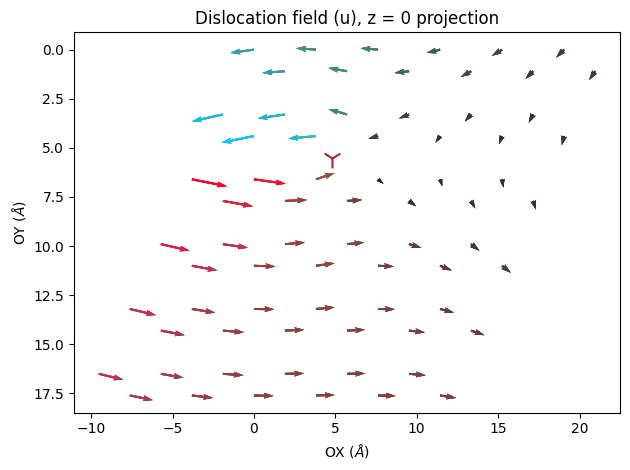

In [7]:
plt.xlabel("OX ($\AA$)")
plt.ylabel("OY ($\AA$)")
plt.title("Dislocation field (u), z = 0 projection")
y_dim = 1
x_dim = 0

plt.quiver(l0.coordinates[..., x_dim], l0.coordinates[..., y_dim], u0[..., x_dim], u0[..., y_dim], 
           color=wzt.visualization.vectors_to_rgb(u0[..., (x_dim, y_dim)]))
plt.scatter(position0[x_dim], position0[y_dim], s=200.5, c="brown", marker="1")
plt.tight_layout()
plt.gca().invert_yaxis()

0.0 0.0
0.0 0.0
-1.1692779071398418 1.252706316646119


/home/pjarosik/src/wurtzite/wurtzite/visualization.py:351: RuntimeWarning: invalid value encountered in scalar divide
  color = matplotlib.colors.hsv_to_rgb((angle/2/np.pi, length/max_abs, length/max_abs))
/home/pjarosik/bin/miniconda3/envs/crystalpy/lib/python3.8/site-packages/matplotlib/quiver.py:646: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/pjarosik/bin/miniconda3/envs/crystalpy/lib/python3.8/site-packages/matplotlib/quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


-1.5189846626670236 1.630948432223695
-1.6237874625203292 1.74470912463015
-1.6552187142134436 1.778865630829383
-1.664647235152306 1.789115198482059
-1.6674757147600858 1.7921903061016098
-1.6683242517482622 1.7931128597983157
-1.668578812224417 1.793389627835702
-1.6686551803114413 1.7934726584205092
-1.6686780907325247 1.7934975676115756


0.0 0.0


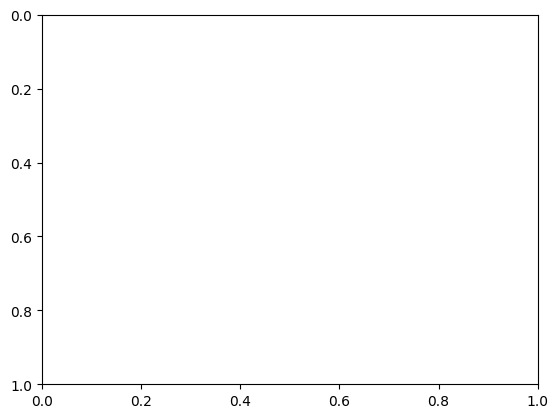

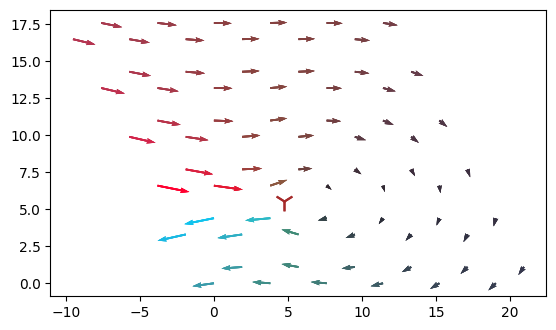

In [8]:
def plot_function(data, fig, ax):
    u = data
    print(np.min(u), np.max(u))
    ax.quiver(l0.coordinates[..., x_dim], l0.coordinates[..., y_dim], u[..., x_dim], u[..., y_dim], 
           color=wzt.visualization.vectors_to_rgb(u[..., (x_dim, y_dim)]))
    ax.scatter(position0[x_dim], position0[y_dim], s=200.5, c="brown", marker="1")
plt.gca().invert_yaxis()
anim = wzt.visualization.create_animation_2d(us, plot_function)
HTML(anim.to_jshtml())

Reading bond: 417/417

<Axes: xlabel='OX ($\\AA$)', ylabel='OY ($\\AA$)'>

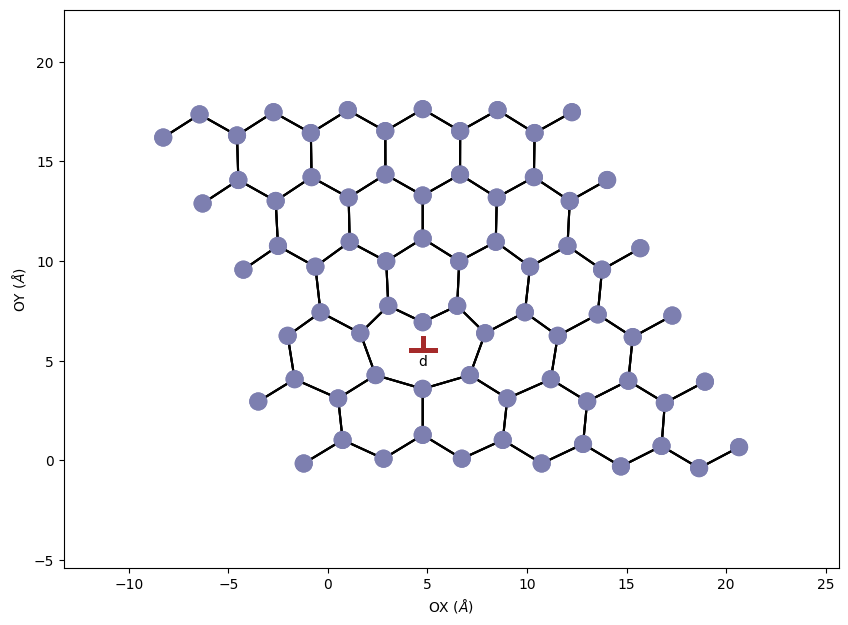

In [9]:
l1 = l0.translate(u0)
l1 = wzt.generate.update_bonds(l1)
fig, ax = wzt.visualization.plot_atoms_2d(l1)
ax.set_aspect("equal")
fig.set_size_inches(10, 10)
wzt.visualization.display_tee_2d(ax, d=d, scale=0.6)

Reading bond: 417/417-1
Reading bond: 417/4170
Reading bond: 414/4141
Reading bond: 417/4172
Reading bond: 417/4173
Reading bond: 417/4174
Reading bond: 417/4175
Reading bond: 417/4176
Reading bond: 417/4177
Reading bond: 417/4178
Reading bond: 417/4179
Reading bond: 417/41710
Reading bond: 417/41711


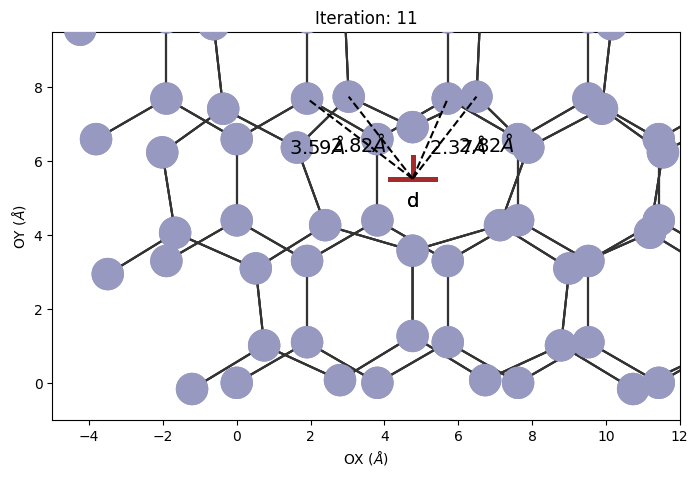

In [13]:
i = -1

def plot_function(data, fig, ax):
    global i
    u = data
    li = l0.translate(u)
    li = wzt.generate.update_bonds(li)
    wzt.visualization.plot_atoms_2d(li, fig=fig, ax=ax, alpha=0.8)
    wzt.visualization.display_tee_2d(ax, d=d, scale=0.6, fontsize=14)
    # 
    a, b = li.coordinates[199], li.coordinates[202]
    a_dist = np.hypot(d.position[0]-a[0], d.position[1]-a[1])
    b_dist = np.hypot(d.position[0]-b[0], d.position[1]-b[1])
    ax.plot([d.position[0], a[0]], [d.position[1], a[1]], zorder=100000, color="black", ls="--")# , marker="_", lw=2, markersize=10)
    ax.plot([d.position[0], b[0]], [d.position[1], b[1]], zorder=100000, color="black", ls="--")# , marker="_", lw=2, markersize=10)
    ax.text(a[0]-0.5, a[1]-1.5, f"${a_dist:2.2f} \\AA$", zorder=100000, fontsize=14)
    ax.text(b[0]-0.5, b[1]-1.5, f"${b_dist:2.2f} \\AA$", zorder=100000, fontsize=14)
    ax.set_xlim(-5, 12)
    ax.set_ylim(-1, 9.5)
    print(i)
    ax.set_title(f"Iteration: {i}")
    i += 1

anim = wzt.visualization.create_animation_2d(us, plot_function, figsize=(10, 5))
# HTML(anim.to_jshtml())
anim.save("single-dislocations.gif")